In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from typing import List, Tuple, Union
from dataclasses import dataclass
from scipy.spatial import distance

In [2]:
rad_measure = pd.read_csv("../data/GT/result.csv")
correct_x = 2
correct_y = 6.5
correct_z = 0.1
correct_value = 8045.0
rad_measure.head(10)

,x,y,z,value,shield
0,1,1,0.1,26.1,A
1,1,1,0.1,257.4,B
2,1,1,0.1,257.4,C
3,1,1,0.1,257.4,D
4,3,1,0.1,257.4,A
5,3,1,0.1,257.4,B
6,3,1,0.1,257.4,C
7,3,1,0.1,26.1,D
8,6,1,0.1,173.9,A
9,6,1,0.1,173.9,B


In [3]:
def calculate_distance(x1, y1, x2, y2):
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

In [4]:
dis_1_B = calculate_distance(correct_x, correct_y, rad_measure['x'][1], rad_measure['y'][1])
const = rad_measure['value'][2] / (correct_value / dis_1_B**2)
print('const : ' + str(const))
dis_4_A = calculate_distance(correct_x, correct_y, rad_measure['x'][4], rad_measure['y'][4])
print(rad_measure['value'][4] * dis_4_A**2 / const)

const : 0.9998446239900558
8045.000000000001


# RBE

In [5]:
# パーティクルの初期化
num_particles = 500
particles = np.random.rand(num_particles, 2) * 10  # パーティクルは0から10の範囲にランダムに配置

weights = np.ones(num_particles) / num_particles

In [6]:
#v_max = max(rad_measure['value'])
v_max = 8045.0
print(v_max)
attenuation = rad_measure['value'][0] / rad_measure['value'][1]
print(attenuation)

8045.0
0.1013986013986014


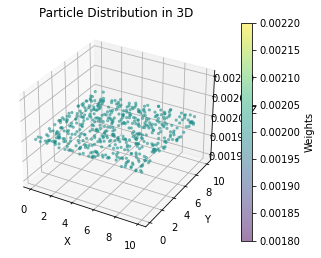

In [7]:
# パーティクルだけを描画する関数
def plot_particles_3d(particles, weights):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(particles[:, 0], particles[:, 1], weights, s=5, c=weights, cmap='viridis', alpha=0.5, label='Particles')

    # カラーバーを表示
    cbar = plt.colorbar(sc)
    cbar.set_label('Weights')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Particle Distribution in 3D')
    plt.show()

plot_particles_3d(particles, weights)

In [8]:
# 平均と標準偏差
mu = 0
sigma = 1/3

# 平均が mu、標準偏差が sigma の正規分布の確率密度関数
def normal_pdf(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

### particleのweightで表現

index:0


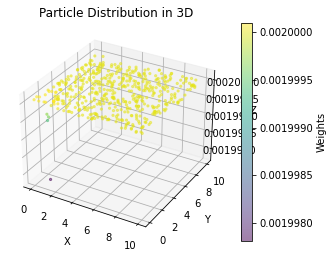

0.30339842874785417 0.6732196232050025


In [9]:
for index,row in rad_measure.iterrows():
    #各計測値
    s_pos = row['shield']
    m_v = row['value']
    m_x = row['x']
    m_y = row['y']
    m_z = row['z']

    #各パーティクルごとに計算
    for i,p in enumerate(particles):
        p_x = p[0]
        p_y = p[1]

        dis = calculate_distance(m_x, m_y, p_x, p_y)

        #例外
        if p_x == m_x or p_y == m_y:
            pass

        if s_pos == 'A':
            if p_x > m_x and p_y > m_y:
                p_v = attenuation * (weights[i] / dis**2) * v_max
                error = abs(m_v - p_v) / v_max
            else:
                p_v = weights[i] / dis**2 * v_max
                error = abs(m_v - p_v) / v_max
        elif s_pos == 'B':
            if p_x > m_x and p_y < m_y:
                p_v = attenuation * (weights[i] / dis**2) * v_max
                error = abs(m_v - p_v) / v_max
            else:
                p_v = weights[i] / dis**2 * v_max
                error = abs(m_v - p_v) / v_max
        elif s_pos == 'C':
            if p_x < m_x and p_y < m_y:
                p_v = attenuation * (weights[i] / dis**2) * v_max
                error = abs(m_v - p_v) / v_max
            else:
                p_v = weights[i] / dis**2 * v_max
                error = abs(m_v - p_v) / v_max
        elif s_pos == 'D':
            if p_x < m_x and p_y > m_y:
                p_v = attenuation * (weights[i] / dis**2) * v_max
                error = abs(m_v - p_v) / v_max
            else:
                p_v = weights[i] / dis**2 * v_max
                error = abs(m_v - p_v) / v_max

        #重みの更新    
        weights[i] = weights[i] * normal_pdf(error, mu, sigma)

    w_sum = sum(weights)
    weights = weights / w_sum

    #パーティクルの描画

    
    if index % 1000 == 0:
        print('index:' + str(index))
        plot_particles_3d(particles, weights)
        max_w = max(weights)
        max_i = list(weights).index(max_w)
        print(particles[max_i][0], particles[max_i][1])


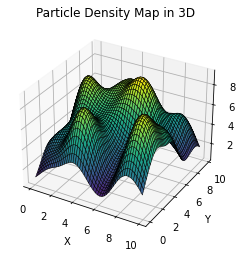

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def calculate_density(particles, particle, bandwidth=1.0):
    # 逆距離法による密度計算
    distances = np.linalg.norm(particles - particle, axis=1)
    kernel_values = np.exp(-0.5 * (distances / bandwidth)**2)
    density = np.sum(kernel_values)
    return density

def plot_particle_density_map(particles, bandwidth=1.0, resolution=50):
    # 密度マップを計算
    x = np.linspace(min(particles[:, 0]), max(particles[:, 0]), resolution)
    y = np.linspace(min(particles[:, 1]), max(particles[:, 1]), resolution)
    xx, yy = np.meshgrid(x, y)
    density_map = np.zeros_like(xx)

    for i in range(resolution):
        for j in range(resolution):
            particle = np.array([xx[i, j], yy[i, j]])
            density_map[i, j] = calculate_density(particles[:, :2], particle, bandwidth)

    # 3Dプロット
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, density_map, cmap='viridis', edgecolors='k', linewidth=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Density')
    ax.set_title('Particle Density Map in 3D')

    plt.show()

# 使用例
num_particles = 100
particles = np.random.rand(num_particles, 2) * 10  # パーティクルは0から10の範囲にランダムに配置

plot_particle_density_map(particles, bandwidth=1.0, resolution=50)


# MLE

### 再急降下法

### b = Aq

In [166]:
rad_measure = pd.read_csv("../data/GT/result.csv")
correct_x = 2
correct_y = 6.5
correct_z = 0.1
correct_value = 8045.0
rad_measure.head(10)

,x,y,z,value,shield
0,1,1,0.1,26.1,A
1,1,1,0.1,257.4,B
2,1,1,0.1,257.4,C
3,1,1,0.1,257.4,D
4,3,1,0.1,257.4,A
5,3,1,0.1,257.4,B
6,3,1,0.1,257.4,C
7,3,1,0.1,26.1,D
8,6,1,0.1,173.9,A
9,6,1,0.1,173.9,B


### データ

In [167]:
#計測値
b = np.array(list(rad_measure['value']))
#grid 20*20
G = 20*20
q_max = 10000
q_init = 1/q_max
q = np.array([q_init]*G)
q = q.astype(float)

#### A

In [168]:
A = np.zeros((144, 400))

for i in range(len(b)):
    m_x = rad_measure['x'][i]
    m_y = rad_measure['y'][i]
    s_pos = rad_measure['shield'][i]
    for j in range(G):
        G_x = (j % 20)*0.5 + 0.25
        G_y = (j//20)*0.5 + 0.25
        dis = calculate_distance(m_x, m_y, G_x, G_y)
        A[i][j] = 1/(dis**2)
        if s_pos == 'A':
            if m_x < G_x and m_y < G_y:
                A[i][j] /= attenuation
        elif s_pos == 'B':
            if m_x < G_x and m_y > G_y:
                A[i][j] /= attenuation
        elif s_pos == 'C':
            if m_x < G_x and m_y > G_y:
                A[i][j] /= attenuation
        elif s_pos == 'D':
            if m_x < G_x and m_y > G_y:
                A[i][j] /= attenuation

In [169]:
def score_func(A,b,q):
    b_ave = A.dot(q)
    score = np.sum(b*np.log(b_ave))-np.sum(b_ave)
    return score

def grad_func(A,b,q):
    b_ave = A.dot(q)
    grad_tmp = (b/b_ave)[:,np.newaxis]*A
    grad = grad_tmp.sum(axis=0) - A.sum(axis=0)
    return grad

In [170]:
optim_factor = 0.00002
init_score = score_func(A,b,q)
print(f'initial score:{init_score}')

initial score:-438731.4634966985


222 1.25 5.75
222 1.25 5.75
222 1.25 5.75
222 1.25 5.75
222 1.25 5.75
222 1.25 5.75
222 1.25 5.75
222 1.25 5.75
222 1.25 5.75


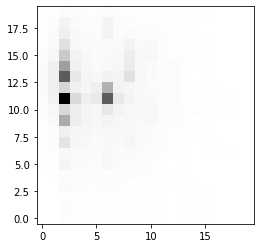

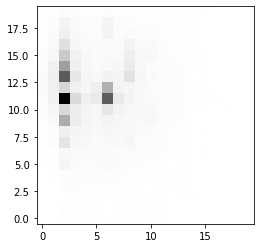

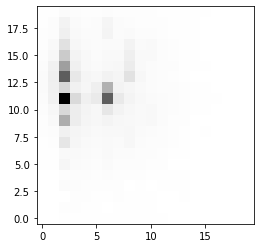

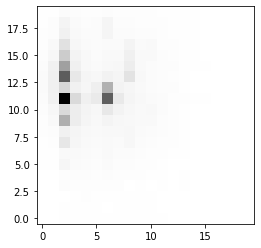

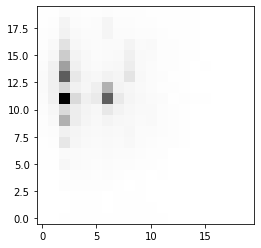

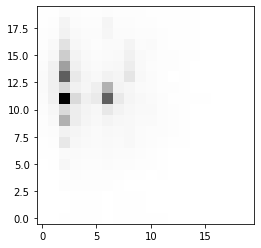

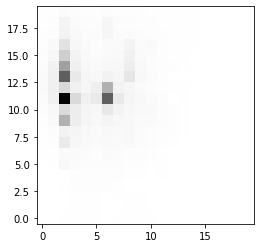

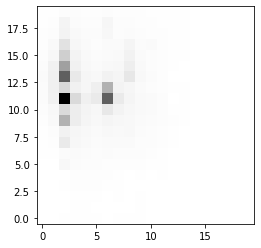

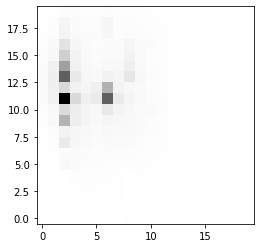

In [172]:
for i in range(1, 10000):
    q_diff = grad_func(A,b,q)
    q += optim_factor*q_diff
    
    # bound > 0
    q[q<0]=0.0000001

    score = score_func(A,b,q)
    if i%1000==0:
        plt.figure()
        #plt.title(f'iter:{i} score:{score} q_max:{q.max():.3}, q_min:{q.min():.3}')
        plt.imshow(q.reshape(20, 20),origin='lower',cmap='Greys')
        #plt.colorbar()
        max_q_i = np.argmax(q)
        max_x = (max_q_i % 20)*0.5 + 0.25
        max_y = (max_q_i//20)*0.5 + 0.25
        print(max_q_i,max_x, max_y)

### 遮蔽無し

In [143]:
rad_measure_ns = pd.read_csv("../data/GT/result_noshield.csv")

In [144]:
x_ns = rad_measure_ns['x']
y_ns = rad_measure_ns['y']
value_ns = rad_measure_ns['value']

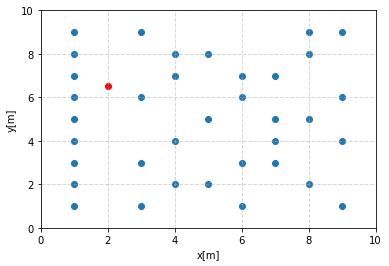

In [163]:
plt.scatter(x_ns, y_ns)
plt.xlabel('x[m]')
plt.ylabel('y[m]')

# x軸とy軸の範囲を[0, 10]に設定
plt.xlim(0, 10)
plt.ylim(0, 10)

plt.scatter(correct_x,correct_y, color='red', label='Red Point')

plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)
plt.show()

In [157]:
A_ns = np.zeros((36, 400))

for i in range(len(value_ns)):
    m_x = rad_measure_ns['x'][i]
    m_y = rad_measure_ns['y'][i]
    for j in range(G):
        G_x = (j % 20)*0.5 + 0.25
        G_y = (j//20)*0.5 + 0.25
        dis = calculate_distance(m_x, m_y, G_x, G_y)
        A_ns[i][j] = 1/(dis**2)

In [158]:
G = 20*20
v_ns = np.array(list(value_ns))
q_ns = np.array([q_init]*G)
q_ns = q_ns.astype(float)

In [160]:
optim_factor = 0.00002
score_func(A_ns,v_ns,q_ns)

-191234.36625971046

262 1.25 6.75
262 1.25 6.75
262 1.25 6.75
262 1.25 6.75
262 1.25 6.75
262 1.25 6.75
262 1.25 6.75
262 1.25 6.75
262 1.25 6.75


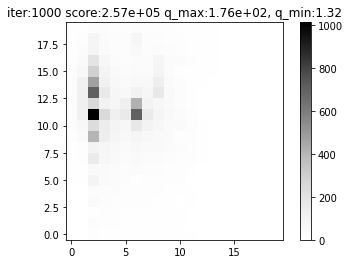

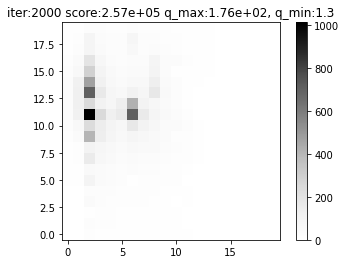

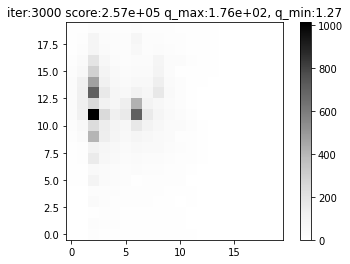

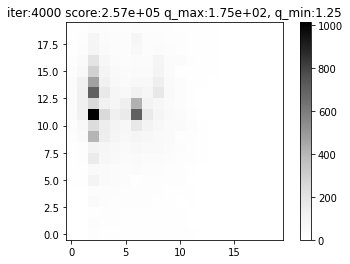

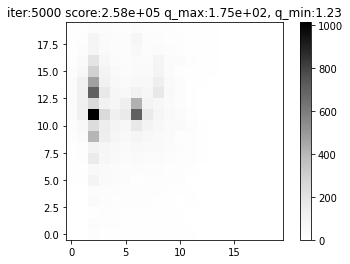

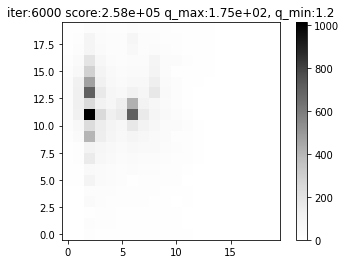

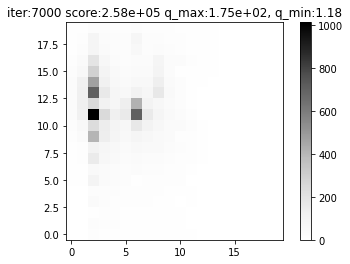

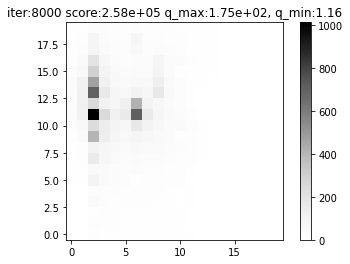

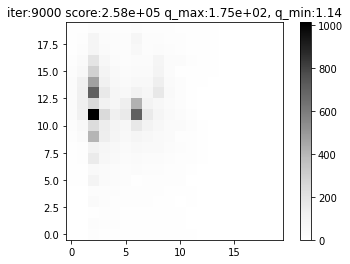

In [165]:
for i in range(1, 10000):
    q_diff_ns = grad_func(A_ns,v_ns,q_ns)
    q_ns += optim_factor*q_diff_ns
    
    # bound > 0
    q_ns[q_ns<0]=0.0000001

    score_ns = score_func(A_ns,v_ns,q_ns)
    if i%1000==0:
        plt.figure()
        plt.title(f'iter:{i} score:{score_ns:.3} q_max:{q_ns.max():.3}, q_min:{q_ns.min():.3}')
        plt.imshow(q.reshape(20, 20),origin='lower',cmap='Greys')
        plt.colorbar()
        max_qns_i = np.argmax(q_ns)
        max_x_ns = (max_qns_i % 20)*0.5 + 0.25
        max_y_ns = (max_qns_i//20)*0.5 + 0.25
        print(max_qns_i,max_x_ns, max_y_ns)